In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
length = 10**6
dt = 0.01
numpy.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length))

Text(0, 0.5, 'Location')

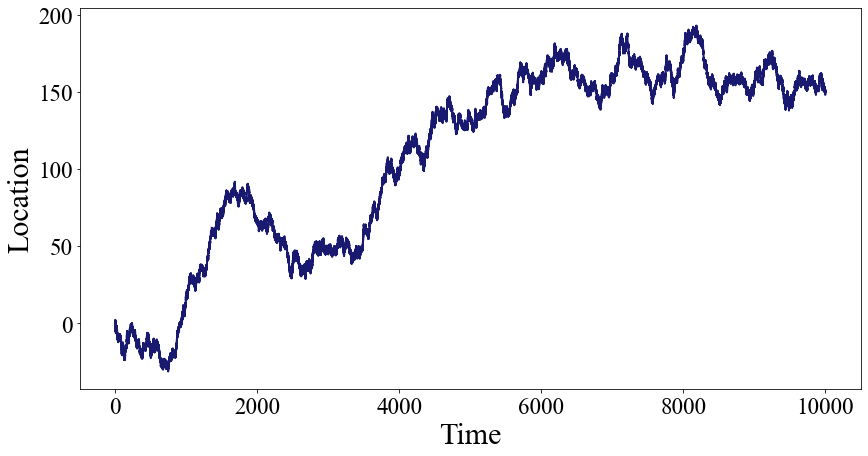

In [3]:
#size of pictures
figsize = 14,7
figure, ax = plt.subplots(figsize=figsize)
 
#Draw two lines on the same picture
plt.plot(dt*np.arange(length),pos,'midnightblue', linewidth = 2)

 
#set the legend and the fontsize 
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
 
#Set the size of the coordinate scale value and the font
plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30,
}

plt.xlabel('Time',font2)
ylabel('Location',font2)
#plt.savefig("./randomwalk.jpg",dpi=1500)  # save

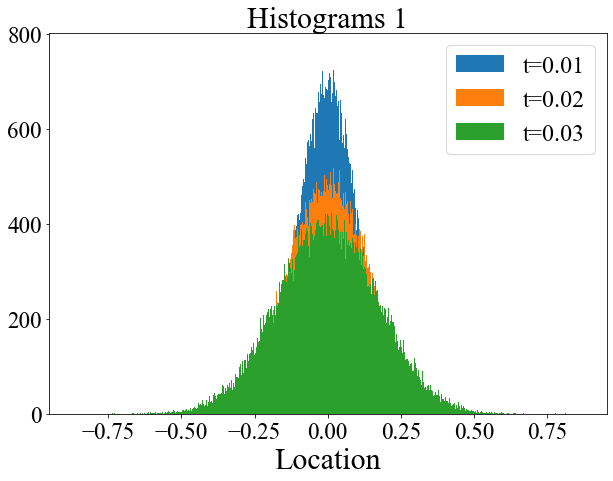

In [4]:
figsize = 10,7
figure, ax = plt.subplots(figsize=figsize)

P = {}
M = 0

m = 3
n = 10000

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = linspace(0,dt*(m-1),m)
U = np.zeros((n,m))

plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
for i in range(m):
    U[:,i] = hist(P[i],bins,label="t="+ str(i*dt+dt))[0]/float(dx*(len(pos)-m))

plt.xlabel('Location', font2)
plt.title('Histograms 1', font2)

plt.legend(loc='upper right',prop={'family':'Times New Roman','weight':'normal','size':24})
plt.savefig("./Histograms1_original.jpg",dpi=2000)  # save

In [6]:
U.shape

(10000, 3)

In [7]:
def build_linear_system(u, dt, dx, D = 3, P = 3,time_diff = 'poly',space_diff = 'poly',lam_t = None,lam_x = None, width_x = None,width_t = None, deg_x = 5,deg_t = None,sigma = 2):


    n, m = u.shape

    if width_x == None: width_x = n/10
    if width_t == None: width_t = m/10
    if deg_t == None: deg_t = deg_x

    # If we're using polynomials to take derviatives, then we toss the data around the edges.
    if time_diff == 'poly': 
        m2 = m-2*width_t
        offset_t = width_t
    else: 
        m2 = m
        offset_t = 0

    if space_diff == 'poly': 
        n2 = n-2*width_x
        offset_x = width_x
    else: 
        n2 = n
        offset_x = 0

    if lam_t == None: lam_t = 1.0/m
    if lam_x == None: lam_x = 1.0/n

    ########################
    # First take the time derivaitve for the left hand side of the equation
    ########################
    

    n2=int(n2)
    m2=int(m2)
    offset_x=int(offset_x)
    ut = np.zeros((n2,m2), dtype=np.complex64)
    print(m2,n2)
    if time_diff == 'FDconv':
        Usmooth = np.zeros((n,m), dtype=np.complex64)
        # Smooth across x cross-sections
        for j in range(m):
            Usmooth[:,j] = ConvSmoother(u[:,j],width_t,sigma)
        # Now take finite differences
        for i in range(n2):
            ut[i,:] = FiniteDiff(Usmooth[i + offset_x,:],dt,1)

    elif time_diff == 'poly':
        T= np.linspace(0,(m-1)*dt,m)
        for i in range(n2):
            ut[i,:] = PolyDiff(u[i+offset_x,:],T,diff=1,width=width_t,deg=deg_t)[:,0]

    elif time_diff == 'Tik':
        for i in range(n2):
            ut[i,:] = TikhonovDiff(u[i + offset_x,:], dt, lam_t)

    else:
        for i in range(n2):
            ut[i,:] = FiniteDiff(u[i + offset_x,:],dt,1)
    
    ut = np.reshape(ut, (n2*m2,1), order='F')

    ########################
    # Now form the rhs one column at a time, and record what each one is
    ########################

    u2 = u[offset_x:n-offset_x,offset_t:m-offset_t]
    Theta = np.zeros((n2*m2, (D+1)*(P+1)), dtype=np.complex64)
    ux = np.zeros((n2,m2), dtype=np.complex64)
    rhs_description = ['' for i in range((D+1)*(P+1))]
    width_x=int(width_x)
    print(width_x)
    if space_diff == 'poly': 
        Du = {}
        for i in range(m2):
            Du[i] = PolyDiff(u[:,i+offset_t],np.linspace(0,(n-1)*dx,n),diff=D,width=width_x,deg=deg_x)
    if space_diff == 'Fourier': ik = 1j*np.fft.fftfreq(n)*n
        
    for d in range(D+1):

        if d > 0:
            for i in range(m2):
                if space_diff == 'Tik': ux[:,i] = TikhonovDiff(u[:,i+offset_t], dx, lam_x, d=d)
                elif space_diff == 'FDconv':
                    Usmooth = ConvSmoother(u[:,i+offset_t],width_x,sigma)
                    ux[:,i] = FiniteDiff(Usmooth,dx,d)
                elif space_diff == 'FD': ux[:,i] = FiniteDiff(u[:,i+offset_t],dx,d)
                elif space_diff == 'poly': ux[:,i] = Du[i][:,d-1]
                elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(ux[:,i]))
        else: ux = np.ones((n2,m2), dtype=np.complex64) 
            
        for p in range(P+1):
            Theta[:, d*(P+1)+p] = np.reshape(np.multiply(ux, np.power(u2,p)), (n2*m2), order='F')

            if p == 1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u'
            elif p>1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u^' + str(p)
            if d > 0: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+\
                                                   'u_{' + ''.join(['x' for _ in range(d)]) + '}'

    return ut, Theta, rhs_description

In [8]:
def FiniteDiff(u, dx, d):### 
    """
    Takes dth derivative data using 2nd order finite difference method (up to d=3)
    Works but with poor accuracy for d > 3
    
    Input:
    u = data to be differentiated
    dx = Grid spacing.  Assumes uniform spacing
    """
    
    n = u.size
    ux = np.zeros(n, dtype=np.complex64)
    
    if d == 1:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-u[i-1]) / (2*dx)
        
        ux[0] = (-3.0/2*u[0] + 2*u[1] - u[2]/2) / dx
        ux[n-1] = (3.0/2*u[n-1] - 2*u[n-2] + u[n-3]/2) / dx
        return ux
    
    if d == 2:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-2*u[i]+u[i-1]) / dx**2
        
        ux[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
        ux[n-1] = (2*u[n-1] - 5*u[n-2] + 4*u[n-3] - u[n-4]) / dx**2
        return ux
    
    if d == 3:
        for i in range(2,n-2):
            ux[i] = (u[i+2]/2-u[i+1]+u[i-1]-u[i-2]/2) / dx**3
        
        ux[0] = (-2.5*u[0]+9*u[1]-12*u[2]+7*u[3]-1.5*u[4]) / dx**3
        ux[1] = (-2.5*u[1]+9*u[2]-12*u[3]+7*u[4]-1.5*u[5]) / dx**3
        ux[n-1] = (2.5*u[n-1]-9*u[n-2]+12*u[n-3]-7*u[n-4]+1.5*u[n-5]) / dx**3
        ux[n-2] = (2.5*u[n-2]-9*u[n-3]+12*u[n-4]-7*u[n-5]+1.5*u[n-6]) / dx**3
        return ux
    
    if d > 3:
        return FiniteDiff(FiniteDiff(u,dx,3), dx, d-3)

In [9]:
def PolyDiff(u, x, deg = 3, diff = 1, width = 5):
    
    """
    u = values of some function
    x = x-coordinates where values are known
    deg = degree of polynomial to use
    diff = maximum order derivative we want
    width = width of window to fit to polynomial

    This throws out the data close to the edges since the polynomial derivative only works
    well when we're looking at the middle of the points fit.
    """

    u = u.flatten()
    x = x.flatten()

    n = len(x)
    du = np.zeros((n - 2*width,diff))

    # Take the derivatives in the center of the domain
    for j in range(width, n-width):

        points = np.arange(j - width, j + width)

        # Fit to a Chebyshev polynomial
        # this is the same as any polynomial since we're on a fixed grid but it's better conditioned :)
        poly = np.polynomial.chebyshev.Chebyshev.fit(x[points],u[points],deg)

        # Take derivatives
        for d in range(1,diff+1):
            du[j-width, d-1] = poly.deriv(m=d)(x[j])

    return du

In [10]:
Ut,R,rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', deg_x = 4)
for func in ['1'] + rhs_des[1:]: print (func)

3 8000
1000
1
u
u^2
u^3
u_{x}
uu_{x}
u^2u_{x}
u^3u_{x}
u_{xx}
uu_{xx}
u^2u_{xx}
u^3u_{xx}
u_{xxx}
uu_{xxx}
u^2u_{xxx}
u^3u_{xxx}


In [11]:
real=np.array([[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.5],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])
A=np.dot(R,real)
B=Ut-A
np.linalg.norm(B)

2441.9148434261874

In [12]:
def TrainSTRidge(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(R,Ut,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol: 
        print ("Optimal tolerance:", tol_best)
    return w_best

def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse 
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0
    
    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
    else: w = np.linalg.lstsq(X,y)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]
    
    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]
            
        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)
            
        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0: 
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds
        
        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]
    
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

In [13]:
def print_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f %+05fi)" % (w[i].real, w[i].imag) + rhs_description[i] + "\n   "
            first = False
    print (pde)

In [14]:
w = TrainSTRidge(R, Ut, 10**-2, 10, normalize = 2)
print_pde(w, rhs_des)

<ipython-input-12-13ac3e2d7f51>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
<ipython-input-12-13ac3e2d7f51>:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
<ipython-input-12-13ac3e2d7f51>:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we ad

u_t = (-10.809766 +0.000000i)u
    + (17.282366 +0.000000i)u^2
    + (-6.807277 +0.000000i)u^3
    + (0.530233 +0.000000i)u_{xx}
    + (-0.078949 +0.000000i)uu_{xx}
    + (-0.022590 +0.000000i)u^2u_{xx}
   


In [15]:
w = TrainSTRidge(R, A, 10**-2, 10, normalize = 2)
print_pde(w, rhs_des)

<ipython-input-12-13ac3e2d7f51>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
<ipython-input-12-13ac3e2d7f51>:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
<ipython-input-12-13ac3e2d7f51>:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we ad

u_t = (0.500000 +0.000000i)u_{xx}
   


In [16]:
Ut.shape

(24000, 1)

In [17]:
def Lasso(X0, Y, lam, w = np.array([0]), maxit = 100, normalize = 2):
    """
    Uses accelerated proximal gradient (FISTA) to solve Lasso
    argmin (1/2)*||Xw-Y||_2^2 + lam||w||_1
    """
    
    # Obtain size of X
    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    Y = Y.reshape(n,1)
    
    # Create w if none is given
    if w.size != d:
        w = np.zeros((d,1), dtype=np.complex64)
    w_old = np.zeros((d,1), dtype=np.complex64)
        
    # Initialize a few other parameters
    converge = 0
    objective = np.zeros((maxit,1))
    
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0

    # Lipschitz constant of gradient of smooth part of loss function
    L = np.linalg.norm(X.T.dot(X),2)
    
    # Now loop until converged or max iterations
    for iters in range(0, maxit):
         
        # Update w
        z = w + iters/float(iters+1)*(w - w_old)
        w_old = w
        z = z - X.T.dot(X.dot(z)-Y)/L
        for j in range(d): w[j] = np.multiply(np.sign(z[j]), np.max([abs(z[j])-lam/L,0]))

        # Could put in some sort of break condition based on convergence here.
    
    # Now that we have the sparsity pattern, used least squares.
    biginds = np.where(w != 0)[0]
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]

    # Finally, reverse the regularization so as to be able to use with raw data
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w


In [19]:
w = Lasso(R, Ut, 250)
print_pde(w, rhs_des)

u_t = (-1.229945 +0.000000i)u^2
    + (0.220074 +0.000000i)u^3
    + (0.432787 +0.000000i)u_{xx}
   


<ipython-input-17-99ee41a4b322>:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]
<ipython-input-17-99ee41a4b322>:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]


In [20]:
w = Lasso(R, A, 250)
print_pde(w, rhs_des)

u_t = (0.500000 +0.000000i)u_{xx}
    + (-0.000000 +0.000000i)uu_{xx}
   


<ipython-input-17-99ee41a4b322>:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]
<ipython-input-17-99ee41a4b322>:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]


In [21]:
import scipy.io as sio
sio.savemat('Randomwalk_pre1_original.mat',{'Ut':A,'R':R})

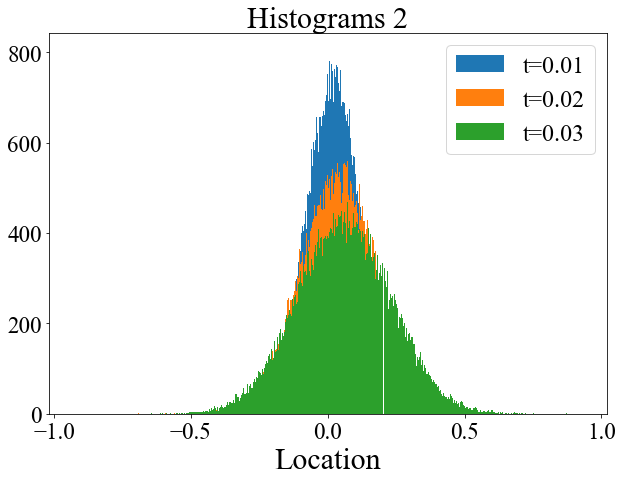

In [36]:
length = 10**6
dt = 0.01
c = 2
numpy.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length)) + c*dt*np.arange(length)

figsize = 10,7
figure, ax = plt.subplots(figsize=figsize)

P = {}
M = 0

m = 3
n = 10000

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = linspace(0,dt*(m-1),m)
U = np.zeros((n,m))

plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
for i in range(m):
    U[:,i] = hist(P[i],bins,label="t="+ str(i*dt+dt))[0]/float(dx*(len(pos)-m))

plt.xlabel('Location', font2)
plt.title('Histograms 2', font2)

plt.legend(loc='upper right',prop={'family':'Times New Roman','weight':'normal','size':24})
plt.savefig("./Histograms2_original.jpg",dpi=2000)  # save

In [37]:
Ut,R,rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', deg_x = 4)
for func in ['1'] + rhs_des[1:]: print (func)

3 8000
1000
1
u
u^2
u^3
u_{x}
uu_{x}
u^2u_{x}
u^3u_{x}
u_{xx}
uu_{xx}
u^2u_{xx}
u^3u_{xx}
u_{xxx}
uu_{xxx}
u^2u_{xxx}
u^3u_{xxx}


In [43]:
w = TrainSTRidge(R, Ut, 10**2, 10, normalize = 2)
print_pde(w, rhs_des)

<ipython-input-12-13ac3e2d7f51>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
<ipython-input-12-13ac3e2d7f51>:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
<ipython-input-12-13ac3e2d7f51>:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we ad

u_t = (0.473123 +0.000000i)u_{xx}
    + (-0.003994 +0.000000i)uu_{xx}
   


In [44]:
real=np.array([[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.473123],[-0.003994],[0.],[0.],[0.],[0.],[0.],[0.]])
A=np.dot(R,real)
B=Ut-A
np.linalg.norm(B)

2913.401114991864

In [45]:
print ("\nPDE derived with STRidge and L^2 normalization (Correct PDE!)")
w = TrainSTRidge(R, A, 10**2, 10, normalize = 2)
print_pde(w, rhs_des)

print ("PDE derived with STRidge without normalization (Incorrect PDE!)")
w = TrainSTRidge(R, A, 10**2, 10, normalize = 0)
print_pde(w, rhs_des)

print ("PDE derived with Lasso (Correct PDE)")
w = Lasso(R, A, 250)
print_pde(w, rhs_des)


PDE derived with STRidge and L^2 normalization (Correct PDE!)


<ipython-input-12-13ac3e2d7f51>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
<ipython-input-12-13ac3e2d7f51>:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
<ipython-input-12-13ac3e2d7f51>:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we ad

u_t = (0.473123 +0.000000i)u_{xx}
    + (-0.003994 +0.000000i)uu_{xx}
   
PDE derived with STRidge without normalization (Incorrect PDE!)
u_t = (0.462746 -0.000000i)u_{xx}
   
PDE derived with Lasso (Correct PDE)


C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


u_t = (0.473123 +0.000000i)u_{xx}
    + (-0.003994 +0.000000i)uu_{xx}
   


<ipython-input-17-99ee41a4b322>:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]
<ipython-input-17-99ee41a4b322>:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y)[0]


In [46]:
sio.savemat('Randomwalk_pre2_original.mat',{'Ut':A,'R':R})